# Gesture Recognition - Siddharth Nagpure, Anjani Devi Nimmakayala
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import warnings
warnings.filterwarnings("ignore")
#import cv2
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 20

In [4]:
print(train_doc[5])
print(val_doc[5])

WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4

WIN_20180907_16_33_15_Pro_Thumbs Down_new;Thumbs Down_new;3



### Image Crop & Resize

In [5]:
#data resizing - Resizing all the images, so we can have all the images in a specific size
def crop_resize_img(img):
  rows = 120
  cols = 120
  if img.shape[0] != img.shape[1]:
    img=img[0:120,10:150]  #crop the image
  resized_image = imresize(img, (rows,cols)) # resize the image
  return resized_image

### Plotting

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'], loc='upper left')

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'], loc='upper left')

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,30,2)]
    x = len(img_idx)
    y = 120
    z = 120
    #print(x)

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
      
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
           
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    resized_img = crop_resize_img(image)
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                batch_labels = batch_labels.astype(np.uint8)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
            # write the code for the remaining data points which are left after full batches
            if (len(t)%batch_size!=0):
              rem_seq = len(t)%batch_size

              for folder in range(rem_seq): # iterate over the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + ((num_batches)*batch_size)].split(';')[0])) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + ((num_batches)*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = crop_resize_img(image) #resizing the image
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
                batch_labels = batch_labels.astype(np.uint8)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()

train_path = 'Project_data/train'
val_path = 'Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Base Model

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from keras.regularizers import l2

In [11]:
#write your model here
num_classes = 5

model = Sequential()

model.add(Conv3D(16, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

#HL1
model.add(Conv3D(32, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

#HL2
model.add(Conv3D(64, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

#HL3
model.add(Conv3D(128, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

#Fully connected
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#output layer
model.add(Dense(num_classes, activation = "softmax"))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 32)     1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'gesture_recog_model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
  os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

W0503 04:17:09.389727 139676061185856 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  34
Val Epoch value:  5


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.6259 - categorical_accuracy: 0.4265Source path =  Project_data/val ; batch size = 20

Epoch 00001: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00001-1.62586-0.42647-2.73234-0.15000.h5
34/34 [==============================] - 31s 915ms/step - loss: 1.6259 - categorical_accuracy: 0.4265 - val_loss: 2.7323 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2070 - categorical_accuracy: 0.5544
Epoch 00002: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00002-1.20697-0.55441-8.36078-0.15000.h5
34/34 [==============================] - 31s 922ms/step - loss: 1.2070 - categorical_accuracy: 0.5544 - val_loss: 8.3608 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9672 - categorical_accuracy: 0.689

Epoch 21/30
34/34 [==============================] - ETA: 0s - loss: 0.5500 - categorical_accuracy: 0.9441
Epoch 00021: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00021-0.54999-0.94412-0.46411-0.82000.h5
34/34 [==============================] - 31s 905ms/step - loss: 0.5500 - categorical_accuracy: 0.9441 - val_loss: 0.4641 - val_categorical_accuracy: 0.8200 - lr: 4.0000e-05
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.5670 - categorical_accuracy: 0.9485
Epoch 00022: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00022-0.56700-0.94853-0.27022-0.92000.h5
34/34 [==============================] - 31s 909ms/step - loss: 0.5670 - categorical_accuracy: 0.9485 - val_loss: 0.2702 - val_categorical_accuracy: 0.9200 - lr: 4.0000e-05
Epoch 23/30
34/34 [==============================] - ETA: 0s - loss: 0.4312 - categorical_accuracy: 0.9588
Epoch 00023: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00023-0.

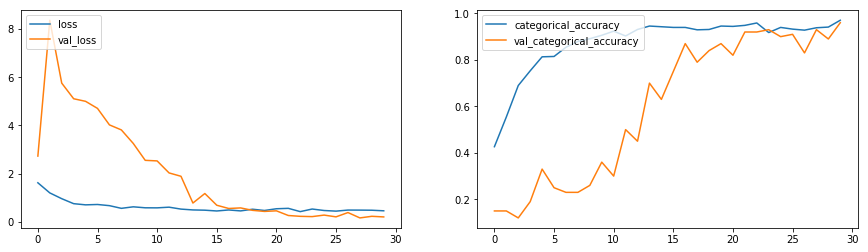

In [15]:
plot(history)

### Observation
Model seems to be performing well with our Base Model, let us try to change filter size to (2,2,2) to reduce number of parameters

# Model 1
Changing filter size to (2,2,2)

In [16]:
#write your model here
num_classes = 5

model1 = Sequential()

model1.add(Conv3D(16, kernel_size = (2,2,2), padding = "same", input_shape = (15,120,120,3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

#HL1
model1.add(Conv3D(32, kernel_size = (2,2,2), padding = "same", input_shape = (15,120,120,3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

#HL2
model1.add(Conv3D(64, kernel_size = (2,2,2), padding = "same", input_shape = (15,120,120,3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

#HL3
model1.add(Conv3D(128, kernel_size = (2,2,2), padding = "same", input_shape = (15,120,120,3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

#Fully connected
model1.add(Flatten())
model1.add(Dense(64, activation = "relu"))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(64, activation = "relu"))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

#output layer
model1.add(Dense(num_classes, activation = "softmax"))

In [19]:
optimiser = "adam"
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 120, 120, 16)  400       
_________________________________________________________________
activation_4 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 60, 60, 32)    

In [20]:
history = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.6792 - categorical_accuracy: 0.4794
Epoch 00001: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00001-1.67918-0.47941-2.88664-0.19000.h5
34/34 [==============================] - 29s 863ms/step - loss: 1.6792 - categorical_accuracy: 0.4794 - val_loss: 2.8866 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.1987 - categorical_accuracy: 0.6279
Epoch 00002: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00002-1.19867-0.62794-6.51741-0.13000.h5
34/34 [==============================] - 30s 890ms/step - loss: 1.1987 - categorical_accuracy: 0.6279 - val_loss: 6.5174 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.1057 - categorical_accuracy: 0.6662
Epoch 00003: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00003-1.10574-0.666

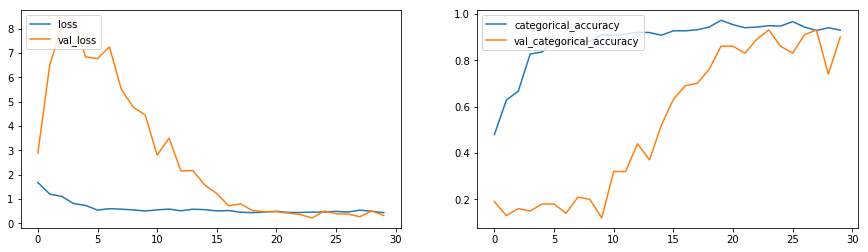

In [21]:
plot(history)

### Observation
Model performance has gone down by a bit by changing filter size. Let us keep the filter size to (3,3,3) and add dropouts at each layer to reduce number of parameters.

# Model 2
Adding droputs at convolution layers

In [22]:
#write your model here
num_classes = 5

model2 = Sequential()

model2.add(Conv3D(16, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model2.add(Dropout(0.25))

#HL1
model2.add(Conv3D(32, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model2.add(Dropout(0.25))

#HL2
model2.add(Conv3D(64, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model2.add(Dropout(0.25))

#HL3
model2.add(Conv3D(128, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model2.add(Dropout(0.25))

#Fully connected
model2.add(Flatten())
model2.add(Dense(64, activation = "relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(Dense(64, activation = "relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

#output layer
model2.add(Dense(num_classes, activation = "softmax"))

In [24]:
optimiser = "adam"
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_9 (Activation)    (None, 8, 60, 60, 32)    

In [25]:
history = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8600 - categorical_accuracy: 0.3500
Epoch 00001: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00001-1.85999-0.35000-2.45390-0.18000.h5
34/34 [==============================] - 32s 935ms/step - loss: 1.8600 - categorical_accuracy: 0.3500 - val_loss: 2.4539 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5358 - categorical_accuracy: 0.4897
Epoch 00002: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00002-1.53576-0.48971-2.83276-0.23000.h5
34/34 [==============================] - 31s 899ms/step - loss: 1.5358 - categorical_accuracy: 0.4897 - val_loss: 2.8328 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3490 - categorical_accuracy: 0.5250
Epoch 00003: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00003-1.34896-0.525

Epoch 21/30
34/34 [==============================] - ETA: 0s - loss: 0.6413 - categorical_accuracy: 0.8471
Epoch 00021: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00021-0.64135-0.84706-1.91481-0.52000.h5
34/34 [==============================] - 31s 915ms/step - loss: 0.6413 - categorical_accuracy: 0.8471 - val_loss: 1.9148 - val_categorical_accuracy: 0.5200 - lr: 1.6000e-06
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.6247 - categorical_accuracy: 0.8485
Epoch 00022: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00022-0.62469-0.84853-1.45472-0.57000.h5
34/34 [==============================] - 31s 910ms/step - loss: 0.6247 - categorical_accuracy: 0.8485 - val_loss: 1.4547 - val_categorical_accuracy: 0.5700 - lr: 1.6000e-06
Epoch 23/30
34/34 [==============================] - ETA: 0s - loss: 0.6460 - categorical_accuracy: 0.8191
Epoch 00023: saving model to gesture_recog_model_2021-05-0218_10_43.426019/model-00023-0.

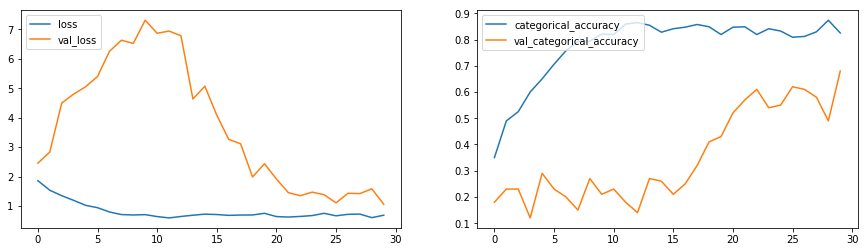

In [26]:
plot(history)

### Observation
Model is not performing well after adding dropouts. Let us try reducing parameters further to check its performance.

# Model 3
Reducing number of parameters

In [14]:
#write your model here
num_classes = 5

model3 = Sequential()

model3.add(Conv3D(8, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model3.add(Dropout(0.25))

#HL1
model3.add(Conv3D(16, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model3.add(Dropout(0.25))

#HL2
model3.add(Conv3D(32, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model3.add(Dropout(0.25))

#HL3
model3.add(Conv3D(64, kernel_size = (3,3,3), padding = "same", input_shape = (15,120,120,3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model3.add(Dropout(0.25))

#Fully connected
model3.add(Flatten())
model3.add(Dense(64, activation = "relu"))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
model3.add(Dense(64, activation = "relu"))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

#output layer
model3.add(Dense(num_classes, activation = "softmax"))

In [15]:
optimiser = "adam"
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 120, 120, 8)   656       
_________________________________________________________________
activation_4 (Activation)    (None, 15, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 16)    

In [16]:
history = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9625 - categorical_accuracy: 0.3515Source path =  Project_data/val ; batch size = 20

Epoch 00001: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00001-1.96247-0.35147-1.91421-0.17000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.9625 - categorical_accuracy: 0.3515 - val_loss: 1.9142 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5731 - categorical_accuracy: 0.4294
Epoch 00002: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00002-1.57306-0.42941-2.89700-0.15000.h5
34/34 [==============================] - 64s 2s/step - loss: 1.5731 - categorical_accuracy: 0.4294 - val_loss: 2.8970 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.4266 - categorical_accuracy: 0.4691
Epoc

Epoch 21/30
34/34 [==============================] - ETA: 0s - loss: 0.8691 - categorical_accuracy: 0.7559
Epoch 00021: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00021-0.86914-0.75588-3.21868-0.35000.h5

Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
34/34 [==============================] - 29s 839ms/step - loss: 0.8691 - categorical_accuracy: 0.7559 - val_loss: 3.2187 - val_categorical_accuracy: 0.3500 - lr: 1.6000e-06
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.9584 - categorical_accuracy: 0.7632
Epoch 00022: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00022-0.95839-0.76324-3.54536-0.30000.h5
34/34 [==============================] - 28s 823ms/step - loss: 0.9584 - categorical_accuracy: 0.7632 - val_loss: 3.5454 - val_categorical_accuracy: 0.3000 - lr: 3.2000e-07
Epoch 23/30
34/34 [==============================] - ETA: 0s - loss: 0.8163 - categorical_accuracy: 0.7765
Epoch 00

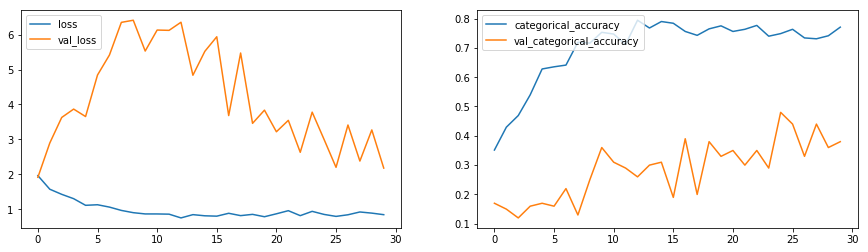

In [17]:
plot(history)

### Observations
Reducing parameters has further reduced validation accuracy as its not to be able to learn generalizable features and its further over-fitting.

# Model 4 - CNN-LSTM Model

In [18]:
#write your model here
num_classes = 5

cnn_rnn_model = Sequential()

cnn_rnn_model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=(15,120,120,3)))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_rnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_rnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_rnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_rnn_model.add(TimeDistributed(Flatten()))
cnn_rnn_model.add(LSTM(128))
cnn_rnn_model.add(Dropout(0.25))
cnn_rnn_model.add(Dense(128,activation='relu'))
cnn_rnn_model.add(Dropout(0.25))

cnn_rnn_model.add(Dense(num_classes, activation='softmax'))

In [19]:
optimiser = "adam"
cnn_rnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_rnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 30, 30, 64)   

In [20]:
history = cnn_rnn_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.4995 - categorical_accuracy: 0.4176
Epoch 00001: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00001-1.49948-0.41765-1.76294-0.27000.h5
34/34 [==============================] - 28s 817ms/step - loss: 1.4995 - categorical_accuracy: 0.4176 - val_loss: 1.7629 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2647 - categorical_accuracy: 0.5529
Epoch 00002: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00002-1.26468-0.55294-1.65023-0.35000.h5
34/34 [==============================] - 29s 840ms/step - loss: 1.2647 - categorical_accuracy: 0.5529 - val_loss: 1.6502 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.1586 - categorical_accuracy: 0.6015
Epoch 00003: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00003-1.15857-0.601

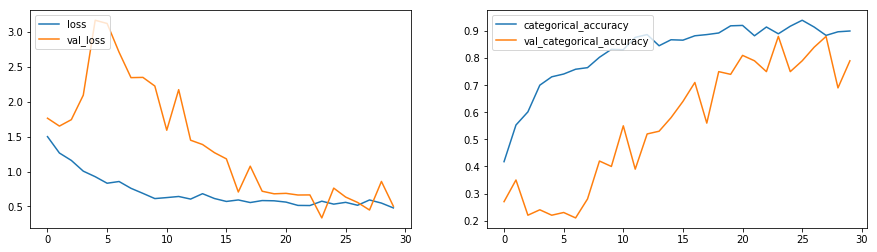

In [21]:
plot(history)

### Observation
Model is performing well, let us use GRU instead of LSTM to reduce parameters.

# Model 5 - CNN-LSTM Model with GRU

In [22]:
#write your model here
num_classes = 5

cnn_rnn_model1= Sequential()

cnn_rnn_model1.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=(15,120,120,3)))
cnn_rnn_model1.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_rnn_model1.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
cnn_rnn_model1.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_rnn_model1.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
cnn_rnn_model1.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
cnn_rnn_model1.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
cnn_rnn_model1.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model1.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_rnn_model1.add(TimeDistributed(Flatten()))
cnn_rnn_model1.add(GRU(128))
cnn_rnn_model1.add(Dropout(0.25))
cnn_rnn_model1.add(Dense(128,activation='relu'))
cnn_rnn_model1.add(Dropout(0.25))
        
cnn_rnn_model1.add(Dense(num_classes, activation='softmax'))

In [23]:
optimiser = "adam"
cnn_rnn_model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_rnn_model1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 30, 30, 64)   

In [24]:
history = cnn_rnn_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.4565 - categorical_accuracy: 0.4647
Epoch 00001: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00001-1.45646-0.46471-2.65216-0.27000.h5
34/34 [==============================] - 29s 852ms/step - loss: 1.4565 - categorical_accuracy: 0.4647 - val_loss: 2.6522 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.1885 - categorical_accuracy: 0.5779
Epoch 00002: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00002-1.18855-0.57794-2.57751-0.14000.h5
34/34 [==============================] - 27s 805ms/step - loss: 1.1885 - categorical_accuracy: 0.5779 - val_loss: 2.5775 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.0254 - categorical_accuracy: 0.6294
Epoch 00003: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00003-1.02539-0.629

Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.6973 - categorical_accuracy: 0.9103
Epoch 00022: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00022-0.69727-0.91029-0.26516-0.90000.h5
34/34 [==============================] - 29s 845ms/step - loss: 0.6973 - categorical_accuracy: 0.9103 - val_loss: 0.2652 - val_categorical_accuracy: 0.9000 - lr: 2.0000e-04
Epoch 23/30
34/34 [==============================] - ETA: 0s - loss: 0.5926 - categorical_accuracy: 0.9132
Epoch 00023: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00023-0.59262-0.91324-0.70876-0.78000.h5
34/34 [==============================] - 29s 845ms/step - loss: 0.5926 - categorical_accuracy: 0.9132 - val_loss: 0.7088 - val_categorical_accuracy: 0.7800 - lr: 2.0000e-04
Epoch 24/30
34/34 [==============================] - ETA: 0s - loss: 0.5150 - categorical_accuracy: 0.9206
Epoch 00024: saving model to gesture_recog_model_2021-05-0220_00_29.714556/model-00024-0.

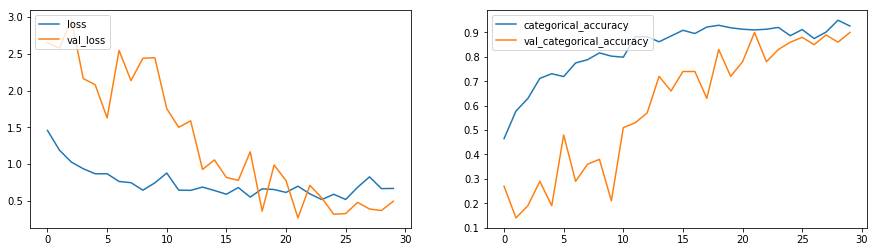

In [25]:
plot(history)

### Observation
Model performance is better with GRU. We will use Transfer learning now for our model

## Model 6 - Transfer Learning

In [13]:
from keras.applications import mobilenet

In [14]:
#write your model here
num_classes = 5

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

cnn_rnn_tl = Sequential()
cnn_rnn_tl.add(TimeDistributed(mobilenet_transfer,input_shape=(15,120,120,3)))
for layer in cnn_rnn_tl.layers:
  layer.trainable = False
cnn_rnn_tl.add(TimeDistributed(BatchNormalization()))
cnn_rnn_tl.add(TimeDistributed(MaxPooling2D((2, 2))))
cnn_rnn_tl.add(TimeDistributed(Flatten()))

cnn_rnn_tl.add(LSTM(128))
cnn_rnn_tl.add(Dropout(0.25))
        
cnn_rnn_tl.add(Dense(128,activation='relu'))
cnn_rnn_tl.add(Dropout(0.25))
        
cnn_rnn_tl.add(Dense(num_classes, activation='softmax'))

W0503 04:17:23.739244 139676061185856 mobilenet.py:216] `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


17227776/17225924 [==============================] - 0s 0us/step


In [15]:
optimiser = "adam"
cnn_rnn_tl.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_rnn_tl.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               590336    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [16]:
history = cnn_rnn_tl.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.4211 - categorical_accuracy: 0.4765Source path =  Project_data/val ; batch size = 20

Epoch 00001: saving model to gesture_recog_model_2021-05-0304_17_09.372367/model-00001-1.42112-0.47647-1.00030-0.62000.h5
34/34 [==============================] - 72s 2s/step - loss: 1.4211 - categorical_accuracy: 0.4765 - val_loss: 1.0003 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.0409 - categorical_accuracy: 0.6632
Epoch 00002: saving model to gesture_recog_model_2021-05-0304_17_09.372367/model-00002-1.04090-0.66324-0.78707-0.71000.h5
34/34 [==============================] - 67s 2s/step - loss: 1.0409 - categorical_accuracy: 0.6632 - val_loss: 0.7871 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.7431 - categorical_accuracy: 0.8088
Epoc

Epoch 21/30
34/34 [==============================] - ETA: 0s - loss: 0.8511 - categorical_accuracy: 0.9088
Epoch 00021: saving model to gesture_recog_model_2021-05-0304_17_09.372367/model-00021-0.85106-0.90882-0.73827-0.74000.h5

Epoch 00021: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
34/34 [==============================] - 28s 815ms/step - loss: 0.8511 - categorical_accuracy: 0.9088 - val_loss: 0.7383 - val_categorical_accuracy: 0.7400 - lr: 4.0000e-05
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 1.0185 - categorical_accuracy: 0.8971
Epoch 00022: saving model to gesture_recog_model_2021-05-0304_17_09.372367/model-00022-1.01847-0.89706-0.38749-0.88000.h5
34/34 [==============================] - 27s 798ms/step - loss: 1.0185 - categorical_accuracy: 0.8971 - val_loss: 0.3875 - val_categorical_accuracy: 0.8800 - lr: 8.0000e-06
Epoch 23/30
34/34 [==============================] - ETA: 0s - loss: 0.9516 - categorical_accuracy: 0.9103
Epoch 00

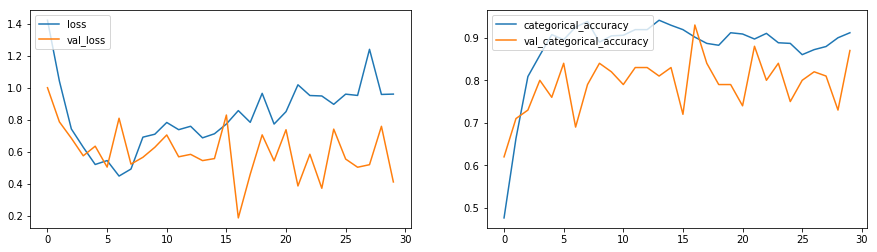

In [17]:
plot(history)

### Observation
For this experiment, Mobilenet layer weights are not trained. Validation accuracy is very poor. So, let us train mobilenet layer’s weights as well

## Model 7 - Transfer Learning with GRU and training all weights

In [18]:
#write your model here
num_classes = 5

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

cnn_rnn_tl1 = Sequential()
cnn_rnn_tl1.add(TimeDistributed(mobilenet_transfer,input_shape=(15,120,120,3)))
for layer in cnn_rnn_tl1.layers:
  layer.trainable = True
cnn_rnn_tl1.add(TimeDistributed(BatchNormalization()))
cnn_rnn_tl1.add(TimeDistributed(MaxPooling2D((2, 2))))
cnn_rnn_tl1.add(TimeDistributed(Flatten()))

cnn_rnn_tl1.add(GRU(128))
cnn_rnn_tl1.add(Dropout(0.25))
        
cnn_rnn_tl1.add(Dense(128,activation='relu'))
cnn_rnn_tl1.add(Dropout(0.25))
        
cnn_rnn_tl1.add(Dense(num_classes, activation='softmax'))

W0503 04:34:31.279704 139676061185856 mobilenet.py:216] `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


In [19]:
optimiser = "adam"
cnn_rnn_tl1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_rnn_tl.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               590336    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [20]:
history = cnn_rnn_tl1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 0.9757 - categorical_accuracy: 0.6941
Epoch 00001: saving model to gesture_recog_model_2021-05-0304_17_09.372367/model-00001-0.97570-0.69412-0.88339-0.72000.h5
34/34 [==============================] - 38s 1s/step - loss: 0.9757 - categorical_accuracy: 0.6941 - val_loss: 0.8834 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.4611 - categorical_accuracy: 0.9221
Epoch 00002: saving model to gesture_recog_model_2021-05-0304_17_09.372367/model-00002-0.46107-0.92206-0.59452-0.78000.h5
34/34 [==============================] - 38s 1s/step - loss: 0.4611 - categorical_accuracy: 0.9221 - val_loss: 0.5945 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.5622 - categorical_accuracy: 0.9074
Epoch 00003: saving model to gesture_recog_model_2021-05-0304_17_09.372367/model-00003-0.56224-0.90735-0.5

34/34 [==============================] - ETA: 0s - loss: 0.8333 - categorical_accuracy: 0.9132
Epoch 00021: saving model to gesture_recog_model_2021-05-0304_17_09.372367/model-00021-0.83329-0.91324-0.32808-0.92000.h5

Epoch 00021: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
34/34 [==============================] - 37s 1s/step - loss: 0.8333 - categorical_accuracy: 0.9132 - val_loss: 0.3281 - val_categorical_accuracy: 0.9200 - lr: 4.0000e-05
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.6577 - categorical_accuracy: 0.9074
Epoch 00022: saving model to gesture_recog_model_2021-05-0304_17_09.372367/model-00022-0.65769-0.90735-0.08105-0.99000.h5
34/34 [==============================] - 38s 1s/step - loss: 0.6577 - categorical_accuracy: 0.9074 - val_loss: 0.0810 - val_categorical_accuracy: 0.9900 - lr: 8.0000e-06
Epoch 23/30
34/34 [==============================] - ETA: 0s - loss: 0.8389 - categorical_accuracy: 0.9118
Epoch 00023: saving model 

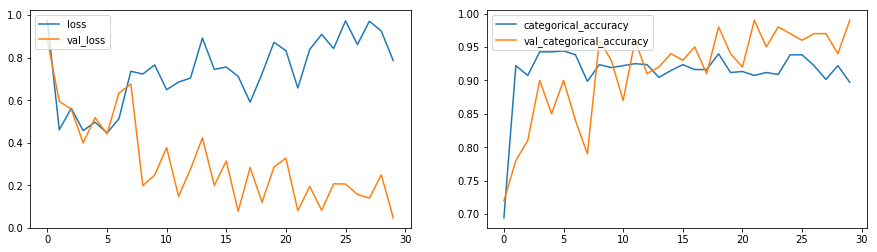

In [21]:
plot(history)

### Observation
We get a better accuracy on training mobilenet layer’s weights as well.

# Consolidated Final Models

| Model name | Model type | No of Params | Model Size (In MBs) | Highest Validation Accuracy | Corrosponding Training Accuracy | Remarks |
|-----|-------|------|------|------|------|------
| model | Conv3D | 822,149 | 9.99 | 0.9600 | 0.9706 | Second Best performing model with low memory footprint |
| model1 | Conv3D | 616,949 | 7.53 | 0.9300 | 0.9485 | Third best model with lowest memory footprint |
| cnn_rnn_tl1 | Transfer Learning with GRU and training all weights | 3,840,453 | 7.53 | 0.9900 | 0.90735 | Best Model in terms of accuracy |